In [1]:
#!pip install opencv-python 
#!pip install cmake
#!pip install opencv-contrib-python
#!pip install dlib

In [2]:
import cv2
import dlib

import os
import matplotlib.pyplot as plt
import numpy as np

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


## Step 1. 스티커 구하기 or 만들기

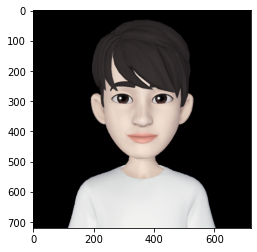

In [3]:
my_image_path = './images/AREmoji_front.png'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 출력용 이미지를 따로 보관.
img_bgr_copy = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # opencv가 인식한 bgr이미지를 rgb형태로 변환.
plt.imshow(img_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출

rectangles[[(230, 231) (498, 498)]]


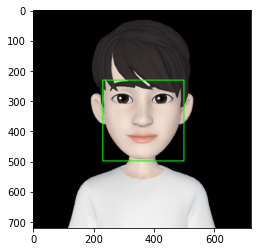

In [4]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [5]:
# dlib에서 제공하는 모델 사용. 공개된 weight file을 사용.
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
# landmark_predictor는 RGB 이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection을 반환
# dlib.rectangle: 내부를 예측하는 박스
# dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄.

In [6]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다.
# face landmark 좌표를 저장해둡니다.
for dlib_rect in dlib_rects:
    # 모든 landmark의 위치정보를 points 변수에 저장
    points = landmark_predictor(img_rgb, dlib_rect)
    # 각각의 landmark 위치 정보를 (x, y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
# 각 원소는 68개의 랜드마크 위치가 나열된 list
# list_landmarks의 원소가 1개이므로 list_landmarks[1]를 호출하면 IndexError.
print(len(list_landmarks[0]))

68


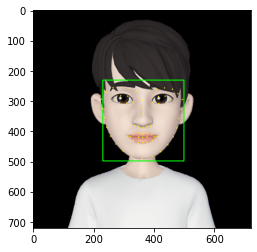

In [7]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print(f'(x,y) : ({x}, {y})')
    print(f'(w,h) : ({w}, {h})')

(364, 367)
(x,y) : (364, 367)
(w,h) : (269, 269)


## Step 4. 스티커 적용하기

In [9]:
sticker_path = './images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(269, 269, 3)


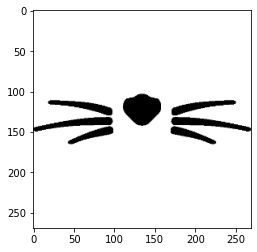

In [10]:
plt.imshow(img_sticker)

In [11]:
refined_x = x - w // 2
refined_y = y - h // 2

print(f'(x,y) : ({refined_x}, {refined_y})')

(x,y) : (230, 233)


In [12]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print(f'(x,y) : ({refined_x}, {refined_y})')

(x,y) : (230, 233)


In [13]:
sticker_area = img_show[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]]
img_show[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

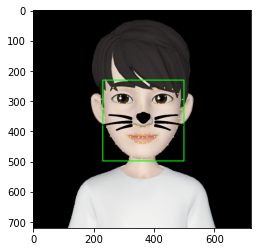

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

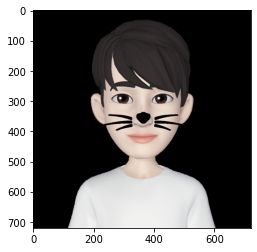

In [15]:
sticker_area = img_bgr[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]]
img_bgr[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5. 문제점 찾아보기

## 여러 케이스를 시도하기위해 함수화

In [16]:
def sticker_image_generator(img_bgr):
    img_show = img_bgr.copy() # 출력용 이미지를 따로 보관.
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # opencv가 인식한 bgr이미지를 rgb형태로 변환.
    plt.imshow(img_rgb)
    plt.show()
    #
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
    dlib_rects = detector_hog(img_rgb, 1)
    print(dlib_rects)

    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()
    #
    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)

        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    print(len(list_landmarks[0]))
    #
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()
    #
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        print(landmark[30])
        x = landmark[30][0]
        y = landmark[30][1]
        w = h = dlib_rect.width()
        print(f'(x,y) : ({x}, {y})')
        print(f'(w,h) : ({w}, {h})')
    #
    sticker_path = './images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    print(img_sticker.shape)
    #
    refined_x = x - w // 2
    refined_y = y - h // 2

    print(f'(x,y) : ({refined_x}, {refined_y})')
    #
    if refined_x < 0:
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    print(f'(x,y) : ({refined_x}, {refined_y})')
    #
    sticker_area = img_show[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]]
    img_show[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
    #
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    #
    sticker_area = img_bgr[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]]
    img_bgr[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

## 밝게

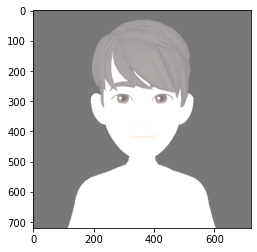

rectangles[[(230, 231) (498, 498)]]


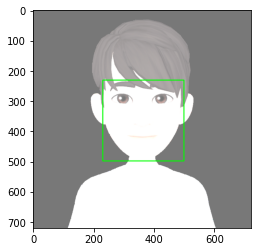

68


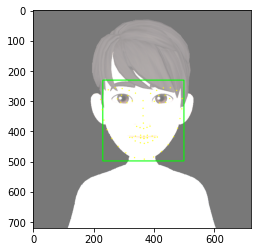

(364, 373)
(x,y) : (364, 373)
(w,h) : (269, 269)
(269, 269, 3)
(x,y) : (230, 239)
(x,y) : (230, 239)


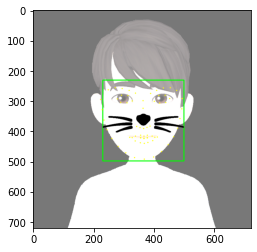

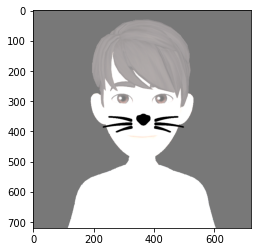

In [17]:
blighter = np.full(img_bgr.shape, (120, 120, 120), dtype=np.uint8)
img_bgr_b = cv2.add(img_bgr_copy, blighter)
sticker_image_generator(img_bgr_b)

## 좀더 밝게

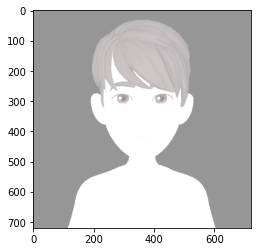

rectangles[]


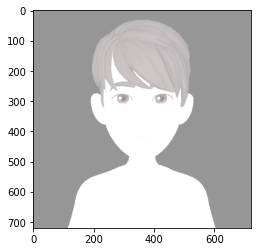

IndexError: list index out of range

In [18]:
blighter = np.full(img_bgr.shape, (150, 150, 150), dtype=np.uint8)
img_bgr_b = cv2.add(img_bgr_copy, blighter)
sticker_image_generator(img_bgr_b)

## 어둡게

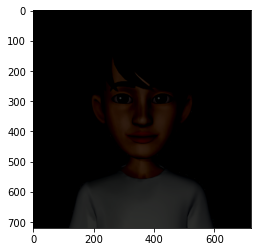

rectangles[[(230, 231) (498, 498)]]


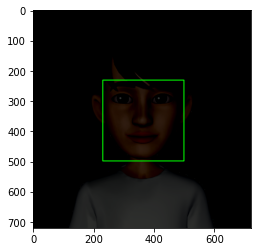

68


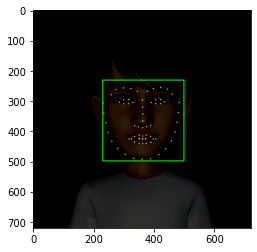

(362, 366)
(x,y) : (362, 366)
(w,h) : (269, 269)
(269, 269, 3)
(x,y) : (228, 232)
(x,y) : (228, 232)


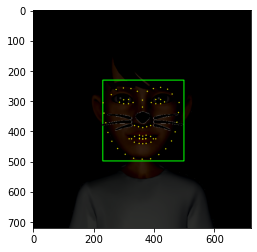

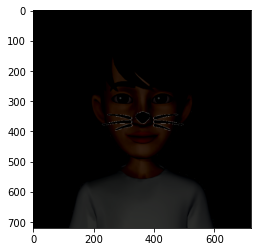

In [19]:
darker = np.full(img_bgr.shape, (-60, -60, -60), dtype=np.uint8)
img_bgr_d = cv2.subtract(img_bgr_copy, darker)
sticker_image_generator(img_bgr_d)

## 좀더 어둡게

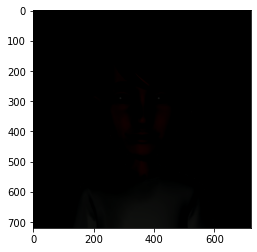

rectangles[]


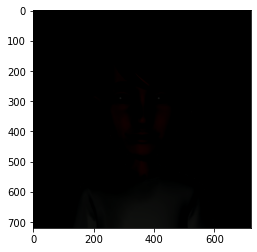

IndexError: list index out of range

In [20]:
darker = np.full(img_bgr.shape, (-30, -30, -30), dtype=np.uint8)
img_bgr_d = cv2.subtract(img_bgr_copy, darker)
sticker_image_generator(img_bgr_d)

## 왼쪽 45?

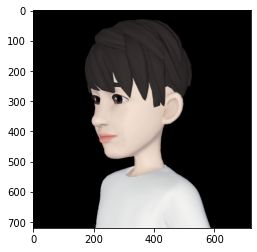

rectangles[[(111, 201) (379, 468)]]


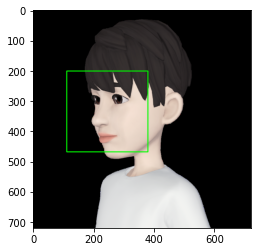

68


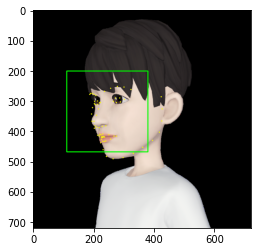

(201, 367)
(x,y) : (201, 367)
(w,h) : (269, 269)
(269, 269, 3)
(x,y) : (67, 233)
(x,y) : (67, 233)


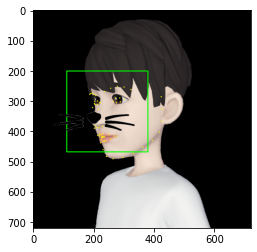

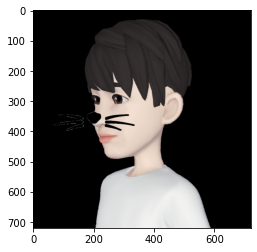

In [21]:
my_image_path = './images/AREmoji_left.png'
img_bgr = cv2.imread(my_image_path)
sticker_image_generator(img_bgr)

## 왼쪽 90?

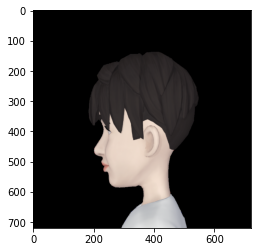

rectangles[]


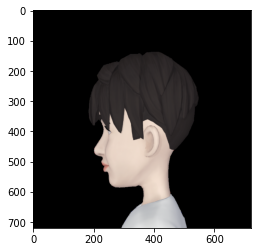

IndexError: list index out of range

In [24]:
my_image_path = './images/AREmoji_left90.png'
img_bgr = cv2.imread(my_image_path)
sticker_image_generator(img_bgr)

## 멀리

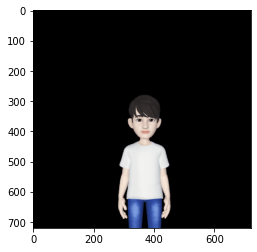

rectangles[[(325, 335) (414, 425)]]


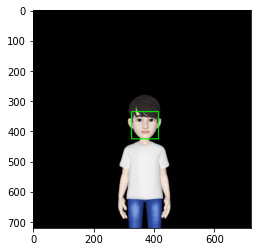

68


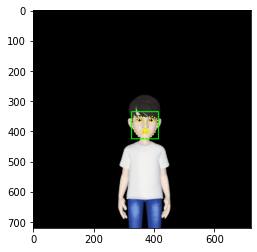

(372, 386)
(x,y) : (372, 386)
(w,h) : (90, 90)
(90, 90, 3)
(x,y) : (327, 341)
(x,y) : (327, 341)


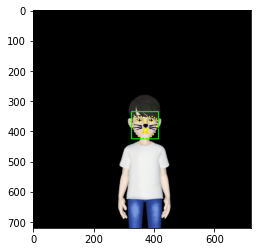

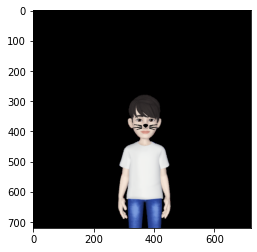

In [23]:
my_image_path = './images/AREmoji_far.png'
img_bgr = cv2.imread(my_image_path)
sticker_image_generator(img_bgr)

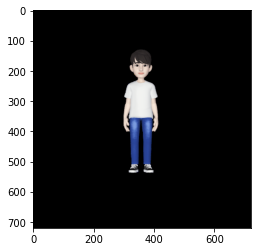

rectangles[[(331, 170) (383, 222)]]


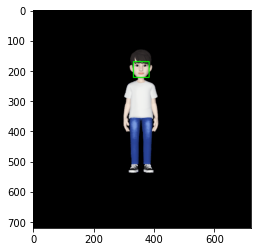

68


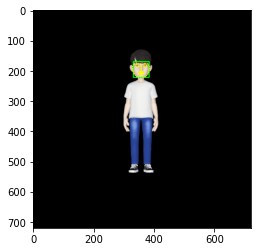

(357, 197)
(x,y) : (357, 197)
(w,h) : (53, 53)
(53, 53, 3)
(x,y) : (331, 171)
(x,y) : (331, 171)


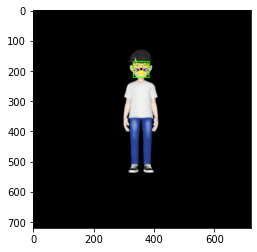

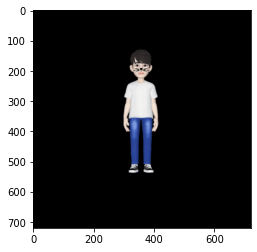

In [26]:
my_image_path = './images/AREmoji_more.png'
img_bgr = cv2.imread(my_image_path)
sticker_image_generator(img_bgr)

# 회고

* 다양한 조건에서의 이미지를 적용했을 때,  

1. 얼굴의 각도가 측면 대각선
측면 45도 정도일때 얼굴을 인식하는것에는 문제는 없었지만, 스티커를 얼굴에 붙일 때, 사진에 붙인것 처럼, 각도에 따른 자연스러움이 부족하게 느껴져서 좀더 자연스러운 형태로 개선할 방법을 생각해야 할 것 같습니다.  
측면 90도 정도일때는 얼굴을 인식할 수 없는 문제가 발생했습니다. 이목구비가 모두 잘 드러나지 않았기에 생기는 문제인것 같습니다.

2. 밝기 차이
어느정도 밝거나 어두운 상태는 문제가 없지만, 매우 어둡거나 매우 밝을 때,  
구체적으로는 코와 입이 인식이 불가능 할 정도의 밝거나 어두운 상태면 얼굴 인식이 안되기 때문에 그 이후 과정인 랜드마크나 스티커를 붙이는 작업이 불가능 해집니다. 

3. 촬영 거리
촬영 거리도 어느정도 거리가 있는 것은 인식이나 스티커를 붙이는데 문제는 없지만, 아주 멀어서 이미지에서 얼굴을 인식하기 어려울 정도로 작아지는 경우에는 다른 경우와 마찬가지로 이후 작업인 랜드마크 검출이나 스티커를 붙이는 작업까지 불가능해집니다.

스티커앱들의 기초적인 부분을 만들어 보면서, 이미지에서 객체를 인식하는데 생기는 문제들을 겪게되어,  
해당 문제들에 대해 개선할 방법들을 고민해 볼 수 있었던 시간이었습니다.